In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import time

import warnings

warnings.filterwarnings('ignore')

In [29]:
np.random.seed(42)
X = np.random.normal(1, 4.5, 10000)
y = np.piecewise(X, [X < -2,(X >= -2) & (X < 2), X >= 2], [lambda X: 2*X + 5, lambda X: 7.3*np.sin(X), lambda X: -0.03*X**3 + 2]) + np.random.normal(0, 1, X.shape)

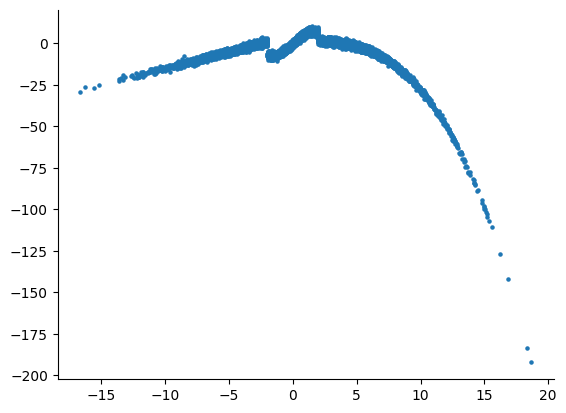

In [35]:
fig, ax = plt.subplots()
plt.scatter(X,y, s=5)
plt.grid(False)
ax.spines[['right', 'top']].set_visible(False)

In [4]:
class ANN(nn.Module):
    def __init__(self, input_size, N, output_size):
        super().__init__()
        self.net = nn.Sequential()
        self.net.add_module(name='Layer_1', module=nn.Linear(input_size, N, bias=False))
        self.net.add_module(name='Tanh',module=nn.Tanh())
        self.net.add_module(name='Layer_2',module=nn.Linear(N, output_size, bias=False))


    def forward(self, x):
        return self.net(x)

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.x = torch.tensor(X)
        self.y = torch.tensor(Y)
        self.len = self.x.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3, random_state = 56, shuffle = True)

In [7]:
train = Dataset(X_train.astype(np.float32), y_train.astype(np.float32))
train_loader = torch.utils.data.DataLoader(train, batch_size=128)

test = Dataset(X_test.astype(np.float32), y_test.astype(np.float32))
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

In [8]:
model = ANN(1,1,1)
loss = nn.MSELoss()

In [9]:
for name, param in model.named_parameters():
    print(name, param.shape)
    print(param)

net.Layer_1.weight torch.Size([1, 1])
Parameter containing:
tensor([[0.1524]], requires_grad=True)
net.Layer_2.weight torch.Size([1, 1])
Parameter containing:
tensor([[0.3015]], requires_grad=True)


In [10]:
model.net._modules['Layer_1'].weight.data

tensor([[0.1524]])

In [11]:
W1, W2 = np.arange(-2, 2, 0.05), np.arange(-2, 2, 0.05)

In [12]:
LOSS = np.zeros((len(W1), len(W2)))
for i, w1 in enumerate(W1):
    model.net._modules['Layer_1'].weight.data = torch.tensor([[w1]], dtype=torch.float32)

    for j, w2 in enumerate(W2):
        model.net._modules['Layer_2'].weight.data = torch.tensor([[w2]], dtype=torch.float32)

        model.eval()
        total_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                preds = model(x.reshape(-1, 1))
                total_loss += loss(preds, y).item()

        LOSS[i, j] = total_loss / len(test_loader)

In [14]:
model = ANN(1,1,1)
epochs = 25
lr = 1e-2

optimizer = optim.SGD(model.parameters(),lr =lr)

model.net._modules['Layer_1'].weight.data = torch.tensor([[-1]], dtype=torch.float32)
model.net._modules['Layer_2'].weight.data = torch.tensor([[-1]], dtype=torch.float32)

In [15]:
errors, weights_1, weights_2 = [], [], []

model.eval()
with torch.no_grad():
    total_loss = 0
    for x, y in test_loader:
        preds = model(x.reshape(-1,1))
        error = loss(preds, y)
        total_loss += error.item()
weights_1.append(model.net._modules['Layer_1'].weight.data.item())
weights_2.append(model.net._modules['Layer_2'].weight.data.item())
errors.append(total_loss / len(test_loader))

for epoch in tqdm(range(epochs)):
    model.train()

    for x, y in train_loader:
        pred = model(x.reshape(-1,1))
        error = loss(pred, y)
        optimizer.zero_grad()
        error.backward()
        optimizer.step()

    model.eval()
    test_preds, true = [], []
    with torch.no_grad():
        total_loss = 0
        for x, y in test_loader:
            preds = model(x.reshape(-1,1))
            error = loss(preds, y)
            test_preds.append(preds)
            true.append(y)

            total_loss += error.item()
    weights_1.append(model.net._modules['Layer_1'].weight.data.item())
    weights_2.append(model.net._modules['Layer_2'].weight.data.item())
    errors.append(total_loss / len(test_loader))

100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


In [27]:
import plotly.graph_objects as go
import plotly.io as pio

plotly_template = pio.templates["plotly_dark"]
fig = go.Figure(data=[go.Surface(z=LOSS, x=W1, y=W2)])

# Update the layout
fig.update_layout(
    title='Loss Surface',
    scene=dict(
        xaxis_title='w1',
        yaxis_title='w2',
        zaxis_title='Loss',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.5),
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False),
        zaxis=dict(showgrid=False),
    ),
    width=800,
    height=800
)


fig.add_trace(go.Scatter3d(x=weights_2, y=weights_1, z=errors,
                               mode='lines+markers',
                              line=dict(color='red', width=2),
                              marker=dict(size=4, color='yellow') ))
fig.show()